In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box, Point, Polygon
import xarray as xr
import rioxarray
from rasterio.features import shapes
import os
import folium
from math import asin, atan2, cos, degrees, radians, sin
from geocube.api.core import make_geocube

root = Path.cwd()

In [2]:
p = pd.read_csv(root / 'suny' / 'SUNY_ESF_CFI_plot_data_1970_2017.csv')

In [3]:
# explore data
for i in set(p.PROPERTY):
    d = p.loc[p.PROPERTY == i]
    print(f'{i}: {[y for y in set(d.YEAR)]}')

for i in set(p.YEAR):
    print(f'{i}: {len(p.loc[p.YEAR == i])} plots')

# select two suitable years (coinciding with Sentinel-2 data)
p1 = p.loc[(p.YEAR == 2013)|(p.YEAR == 2016)]

# create geodataframe
geometry = gpd.points_from_xy(p1.LONGITUDE, p1.LATITUDE, crs='EPSG:4326')
p1['geometry'] = geometry
plots = gpd.GeoDataFrame(p1,geometry='geometry',crs='EPSG:4326')
# save to disk
#plots.to_file(root / 'suny' / 'plots_2013_2016.gpkg')

HMF: [1984, 1987, 1989, 1990, 2000, 2010, 1981, 1982, 1983]
PDF: [1993, 2003, 2013, 1983]
PEF: [2017, 1996, 1989, 2006]
HWF: [1991, 2001, 1970, 2011, 1981]
DMF: [2016, 1996, 1989, 2006]
1970: 171 plots
1981: 334 plots
1982: 54 plots
1983: 140 plots
1984: 37 plots
1987: 10 plots
1989: 102 plots
1990: 189 plots
1991: 288 plots
1993: 95 plots
1996: 106 plots
2000: 212 plots
2001: 288 plots
2003: 95 plots
2006: 106 plots
2010: 212 plots
2011: 288 plots
2013: 95 plots
2016: 79 plots
2017: 27 plots


C:\Users\roseh\AppData\Local\Temp\ipykernel_18796\840183548.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1['geometry'] = geometry


In [4]:
# check out plot locations
plots.explore(markertype='circle',popup=True,color='red',marker_kwds={'radius':1,'fill':True})

In [4]:
# read in tree csv
t = pd.read_csv(root / 'suny' / 'SUNY_ESF_CFI_tree_data_1970_2017.csv')
# select 2013 and 2016 data
t = t.loc[(t.YEAR == 2013)| (t.YEAR == 2016)]
# join tree to plot data
trees = plots.merge(t,on=['YEAR','PLOT_ID'])

# convert feet to meters
trees['DIST_CENTER_METERS'] = trees['DIST_CENTER'] / 3.281 

In [11]:
# function to get point locations of trees based on azimuth and distance from plot center
def get_point_at_distance(x):  
  
    R=6371000  # mean earth radius in meters
    lat1 = radians(x['LATITUDE'])
    lon1 = radians(x['LONGITUDE'])
    a = radians(x['AZIMUTH'])
    d = x['DIST_CENTER_METERS']

    # mathy math
    lat2 = asin(sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(a))
    lon2 = lon1 + atan2(
        sin(a) * sin(d/R) * cos(lat1),
        cos(d/R) - sin(lat1) * sin(lat2)
    )

    return Point(degrees(lon2), degrees(lat2))

# apply function to trees df
trees['tree_point'] = trees.apply(get_point_at_distance,axis=1)

# set tree point locations as new geometry column
trees_points = trees.set_geometry('tree_point',crs="EPSG:4326").drop('geometry',axis=1)

In [9]:
trees_points.columns

Index(['PLOT_ID', 'Property', 'TREE_ID', 'taxonID', 'dbh_inches',
       'tree_point'],
      dtype='object')

In [12]:
# filter out dead or small trees
trees_points = trees_points.loc[(trees_points['CROWN_CLASS']!=4.0)&(trees_points['CROWN_CLASS']!=0.0)]

# select columns to keep
trees_points = trees_points[['PLOT_ID','PROPERTY_x','TREE_ID', 'SPECIES',  'DBH', 'tree_point']]
trees_points = trees_points.rename(columns={'PROPERTY_x': 'Property','DBH':'dbh_inches','SPECIES':'taxonID'})

tree_codes = {12:'balsam_fir',71: 'tamarack',91:'spruce',94:'spruce', 95: 'spruce',97: 'spruce',105: 'pine', 125: 'pine', 129:'pine', 130: 'pine', 261:'hemlock',316:'maple',318:'maple',371:'birch', 372: 'birch', 375: 'birch', 531:'beech',541:'ash', 543: 'ash', 743:'aspen',746: 'aspen', 762:'cherry',833:'oak',950: 'basswood',970: 'elm',999:'unknown'}

trees_points['taxonID'] = trees_points['taxonID'].map(tree_codes)


In [13]:
suny = trees_points.loc[trees_points['Property']=='DMF']
lathrop = trees_points.loc[trees_points['Property']!='DMF']

In [14]:
suny['taxonID'].value_counts()

taxonID
pine          560
maple         497
spruce        218
beech         191
cherry        183
balsam_fir    112
birch          71
aspen          31
tamarack       15
ash            12
unknown         8
hemlock         2
Name: count, dtype: int64

In [111]:
suny = suny.to_crs(26918)
suny.to_file(root / 'output' / 'SUNY' / 'all_trees_SUNY.gpkg')

In [112]:
lathrop = lathrop.to_crs(26918)
lathrop.to_file(root / 'output' / 'SUNY' / 'all_trees_LATHROP.gpkg')

In [32]:
# map tree locations

m = folium.Map(location= tuple([44.147865, -74.904591]), zoom_start=11)

folium.GeoJson(
    plots,
    marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1)
).add_to(m)

folium.GeoJson(
    trees_points,
    marker=folium.Circle(radius=2, fill_color="blue", fill_opacity=0.4, color="blue", weight=1),
    tooltip=folium.GeoJsonTooltip(
    fields=["taxonID"])
).add_to(m)

m



In [97]:
import hvplot.xarray  

bands = xr.open_dataarray(root / 'sentinel_data' / 'suny' / '2018_suny_aligned_bands.nc')
bands = bands.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
b = bands.isel(time=3,band=3)
b = b.rio.reproject("EPSG:4326")


b.hvplot.image(
    x='x',
    y='y',
    cmap='viridis',
    rasterize=True,
    geo=True,
    tiles='OSM',  
    frame_width=500,
    dynamic=True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'455d6e3d-358d-4ba8-8b52-fc660b8f68a3': {'version…

In [ ]:
# grid needs to be 0.1 spacing for xarray-leaflet to work.

# from ipyleaflet import Map, basemaps
# import xarray_leaflet
# import rasterio

# m = Map(center=[44, -74], zoom=9, basemap=basemaps.OpenStreetMap.Mapnik, interpolation='nearest')


# b = b.rio.write_nodata(np.nan)

# b_resampled = b.rio.reproject(
#     "EPSG:4326",
#     resolution=0.1,
#     resampling=rasterio.enums.Resampling.nearest  # Or .bilinear, .nearest
# )

# b_resampled.leaflet.plot(m, colormap='vidiris')

# m

In [ ]:
# to do: 
# identify plots with >80% basal area of given species
# gudex-cross has between 1 - 11 plots for each species and total of 54 plots

# to get plot boundaries: for each plot id get envelope of associated trees

In [80]:
# Check spacing in latitude and longitude
lat_diffs = np.diff(b['y'].values)  # or 'latitude' or 'lat', depending on your dataset
lon_diffs = np.diff(b['x'].values)  # or 'longitude' or 'lon'

# Check if spacing is ~0.1 degrees and uniform
lat_regular = np.allclose(lat_diffs, 0.1) or np.allclose(lat_diffs, -0.1)
lon_regular = np.allclose(lon_diffs, 0.1) or np.allclose(lon_diffs, -0.1)

print("Latitude grid regular:", lat_regular)
print("Longitude grid regular:", lon_regular)
print("Lat spacing (sample):", lat_diffs[:5])
print("Lon spacing (sample):", lon_diffs[:5])

Latitude grid regular: False
Longitude grid regular: False
Lat spacing (sample): [-0.00010976 -0.00010976 -0.00010976 -0.00010976 -0.00010976]
Lon spacing (sample): [0.00010976 0.00010976 0.00010976 0.00010976 0.00010976]


In [3]:
dbh_column = 'DBH'
epsg = 26918
sentinel_filename = '2018_suny_dmf'
species_colname = 'SPECIES'
beech_code = 531.0

# read in sentinel
r = xr.open_dataarray(root /'sentinel_data' /f'{sentinel_filename}.nc')
r = r.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
r1 = r.isel(band=1,time=1)
# read in tree points
trees = gpd.read_file(root / 'suny' / 'tree_points_2016_2013.gpkg')
trees = trees.to_crs(epsg)

# vectorize raster
polygons = shapes(r1.values, transform=r1.rio.transform())
# Create a list of dictionaries for each polygon
geometry = []
ids = []
i = 1
for polygon, value in polygons:
        geometry.append(polygon)
        ids.append(i)
        i += 1   

# Create a GeoDataFrame from the features
gdf_dict = {'geometry':[Polygon(x['coordinates'][0]) for x in geometry],'cell_id':list(range(1,len(geometry)+1))}

gdf = gpd.GeoDataFrame(gdf_dict, crs=r1.rio.crs)

# join tree points to polygons
j = gpd.sjoin(gdf, trees, predicate='contains')

# dbh in inches gives basal area in sqare feet
j['basal_area'] = .005454 * j[dbh_column]**2

# make beech basal area column
j['beech_basal_area'] = j.apply(lambda row: row['basal_area'] if row[species_colname] == beech_code else 0, axis=1)

# get total basal area per species per pixel
total_basal_area = j.groupby(['cell_id'])['beech_basal_area'].sum().reset_index()

#beech = total_basal_area.loc[total_basal_area['SPECIES']==531.0]
# join result back to spatial data
beech_merged = gdf.merge(total_basal_area,on='cell_id',how='inner')
# convert basal area sq.ft to sq. meters
beech_merged['beech_basal_area_meters'] = beech_merged['beech_basal_area']/10.764

# get percent basal area per 100 sq. meter pixel
beech_merged['percent_beech_basal_area'] = beech_merged['beech_basal_area_meters']/100

g = make_geocube(
vector_data=beech_merged,
measurements=["percent_beech_basal_area"],
like=r1, # ensure the data are on the same grid
)


In [5]:
# there are 1827 unique cell_ids (pixels) containing 1-3 trees each
# this brings length of joined dataframe up to 1897 rows (some cell_ids repeat due to multiple trees)

g.to_netcdf(root / 'output' / 'suny' / 'percent_basal_area_suny.nc')

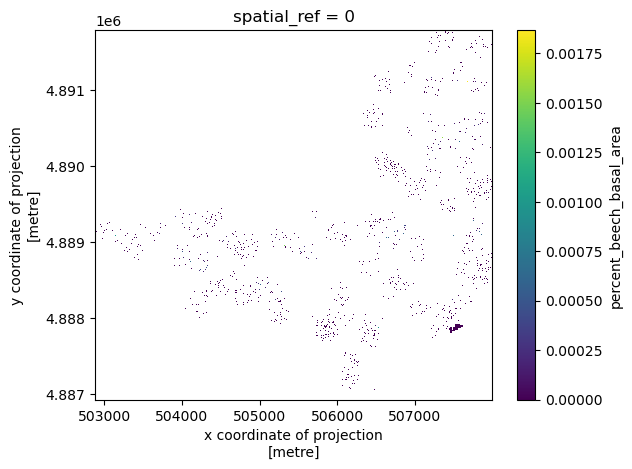

In [4]:
g.percent_beech_basal_area.plot()  # 190 overstory beech trees located in 182 pixels

plt.show()